In [5]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from os.path import join
device = "cuda" if torch.cuda.is_available() else "cpu"

Try to study the dino v2 base model (distilled from the giant model)

In [2]:
dinov2_vitb14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/main.zip
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_reg4_pretrain.pth" to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/bin

In [ ]:
dinov2_vitb14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
model = dinov2_vitb14_reg.eval().to(device)
model.requires_grad_(False)
transforms_pipeline = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### test out the transformation pipeline

In [10]:
from torchvision import transforms as T
import torchvision.transforms as transforms
transforms_pipeline = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transforms_pipeline_orig = transforms.Compose([
    transforms.ToTensor(),
    T.Resize((224, 224)),
    lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
    transforms.Normalize(
        mean=(123.675, 116.28, 103.53),
        std=(58.395, 57.12, 57.375),
    ),
])

In [23]:
# print more digits of the mean and std 6 decimal places
print([ f"{num/255.0:.6f}" for num in [123.675, 116.28, 103.53]])
print([f"{num/255.0:.6f}" for num in [58.395, 57.12, 57.375]])

['0.485000', '0.456000', '0.406000']
['0.229000', '0.224000', '0.225000']


In [26]:
from PIL import Image
import numpy as np
img = Image.fromarray(np.random.randint(0, 255, (256, 256, 3), dtype=np.uint8))
img_pp_custom= transforms_pipeline(img)
img_pp_orig = transforms_pipeline_orig(img)
assert torch.allclose(img_pp_orig, img_pp_custom, atol=1e-6)


### Fit encoding models for vision transformer

In [61]:
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import os
from os.path import join
import torch as th
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from circuit_toolkit.plot_utils import show_imgrid
from circuit_toolkit.layer_hook_utils import featureFetcher
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from circuit_toolkit.plot_utils import saveallforms
from core.data_utils import load_neural_data, load_from_hdf5, parse_image_fullpaths
from core.model_load_utils import load_model_transform
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit

In [31]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"

In [32]:
stimuli_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli"
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"

data_path = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
# datapath_day3 = join(ephys_root, "vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5")

imgdir_shared = join(stimuli_root, "shared1000")
imgdir = join(stimuli_root, "stimuli_pilot_20241119/results")
# imgdir_day3 = join(stimuli_root, "results_12-01-2025")
data = load_from_hdf5(data_path)
print("subjects:", list(data.keys()))

subjects: ['red_20241212-20241220']


In [33]:
subject_id = 'red_20241212-20241220'
data_dict = load_neural_data(data_path, subject_id, None)
data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [imgdir_shared, imgdir])
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
figdir = join(dataroot, subject_id, "model_outputs")
os.makedirs(figdir, exist_ok=True)

All stimulus files were found


In [37]:
batch_size = 96
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
# for modelname in ["dinov2_vitb14_reg", ]: # 
modelname = "dinov2_vitb14_reg"
# model, transforms_pipeline = load_model_transform(modelname, device=device)

dinov2_vitb14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
model = dinov2_vitb14_reg.eval().to(device)
model.requires_grad_(False)
transforms_pipeline = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare dataset with transforms
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
# Prepare fetcher
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values() if ".blocks.NestedTensorBlock" in name]
# Add hooks to all layers / blocks in resnet50
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

# # Record features
feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()
th.cuda.empty_cache()

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main


The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

.blocks.NestedTensorBlock0 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock1 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock2 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock3 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock4 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock5 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock6 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock7 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock8 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock9 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock10 torch.Size([1028, 261, 768])
.blocks.NestedTensorBlock11 torch.Size([1028, 261, 768])
FeatureFetcher hooks all freed


In [35]:
fetcher.module_names

OrderedDict([('0', 'Image'),
             ('1', '.patch_embed.Conv2dproj'),
             ('2', '.patch_embed.Identitynorm'),
             ('3', '.PatchEmbedpatch_embed'),
             ('4', '.blocks.0.LayerNormnorm1'),
             ('5', '.blocks.0.attn.Linearqkv'),
             ('6', '.blocks.0.attn.Linearproj'),
             ('7', '.blocks.0.attn.Dropoutproj_drop'),
             ('8', '.blocks.0.MemEffAttentionattn'),
             ('9', '.blocks.0.LayerScalels1'),
             ('10', '.blocks.0.LayerNormnorm2'),
             ('11', '.blocks.0.mlp.Linearfc1'),
             ('12', '.blocks.0.mlp.GELUact'),
             ('13', '.blocks.0.mlp.Dropoutdrop'),
             ('14', '.blocks.0.mlp.Linearfc2'),
             ('15', '.blocks.0.mlp.Dropoutdrop'),
             ('16', '.blocks.0.Mlpmlp'),
             ('17', '.blocks.0.LayerScalels2'),
             ('18', '.blocks.NestedTensorBlock0'),
             ('19', '.blocks.1.LayerNormnorm1'),
             ('20', '.blocks.1.attn.Linearqkv'),


In [39]:
from dinov2.models.vision_transformer import DinoVisionTransformer

### Neural Regression and prediction

In [51]:
from neural_regress.regress_lib import transform_features2Xdict, sweep_regressors, MultiTaskLassoCV, MultiOutputSeparateLassoCV, RidgeCV

In [48]:
import time



In [41]:
def get_cls_token(X):
    return X[:, 0, :]

def get_mean_register_token(X):
    return X[:, 1:5, :].mean(dim=1)

def get_maxpool_space_token(X):
    return X[:, 5:, :].max(dim=1)[0]

def get_avgpool_space_token(X):
    return X[:, 5:, :].mean(dim=1)

def get_cls_cat_maxpool_space_token(X):
    return torch.cat([get_cls_token(X), get_maxpool_space_token(X)], dim=1)

In [46]:
Xtransforms_dict = {
    "cls_token": get_cls_token,
    "mean_register_token": get_mean_register_token,
    "maxpool_space_token": get_maxpool_space_token,
    "avgpool_space_token": get_avgpool_space_token,
    "cls_cat_maxpool_space_token": get_cls_cat_maxpool_space_token,
}

In [49]:
Xdict_lyrswp = {}
Xtfmer_lyrswp = {}
for layer in module_names:
    for dimred_str, transform_func in Xtransforms_dict.items():
        t0 = time.time()
        Xdict_lyrswp[f"{layer}_{dimred_str}"] = transform_func(feat_dict_lyrswp[layer])
        Xtfmer_lyrswp[f"{layer}_{dimred_str}"] = transform_func
        print(f"Time taken to transform {layer} x {dimred_str}: {time.time() - t0:.3f}s")

Time taken to transform .blocks.NestedTensorBlock0 x cls_token: 0.000s
Time taken to transform .blocks.NestedTensorBlock0 x mean_register_token: 0.002s
Time taken to transform .blocks.NestedTensorBlock0 x maxpool_space_token: 0.324s
Time taken to transform .blocks.NestedTensorBlock0 x avgpool_space_token: 0.072s
Time taken to transform .blocks.NestedTensorBlock0 x cls_cat_maxpool_space_token: 0.301s
Time taken to transform .blocks.NestedTensorBlock1 x cls_token: 0.000s
Time taken to transform .blocks.NestedTensorBlock1 x mean_register_token: 0.002s
Time taken to transform .blocks.NestedTensorBlock1 x maxpool_space_token: 0.296s
Time taken to transform .blocks.NestedTensorBlock1 x avgpool_space_token: 0.073s
Time taken to transform .blocks.NestedTensorBlock1 x cls_cat_maxpool_space_token: 0.298s
Time taken to transform .blocks.NestedTensorBlock2 x cls_token: 0.000s
Time taken to transform .blocks.NestedTensorBlock2 x mean_register_token: 0.002s
Time taken to transform .blocks.NestedTens

In [52]:
resp_mat_sel = resp_mat
# Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken", "clstoken"],  #  "srp"
#                                                         pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

.blocks.NestedTensorBlock0_cls_token RidgeCV D2_train: 0.096 D2_test: 0.097 time: 0.363
.blocks.NestedTensorBlock0_mean_register_token RidgeCV D2_train: 0.099 D2_test: 0.065 time: 0.255
.blocks.NestedTensorBlock0_maxpool_space_token RidgeCV D2_train: 0.135 D2_test: 0.047 time: 0.259
.blocks.NestedTensorBlock0_avgpool_space_token RidgeCV D2_train: 0.163 D2_test: 0.092 time: 0.258
.blocks.NestedTensorBlock0_cls_cat_maxpool_space_token RidgeCV D2_train: 0.138 D2_test: 0.049 time: 0.202
.blocks.NestedTensorBlock1_cls_token RidgeCV D2_train: 0.205 D2_test: 0.132 time: 0.257
.blocks.NestedTensorBlock1_mean_register_token RidgeCV D2_train: 0.244 D2_test: 0.141 time: 0.258
.blocks.NestedTensorBlock1_maxpool_space_token RidgeCV D2_train: 0.278 D2_test: 0.084 time: 0.261
.blocks.NestedTensorBlock1_avgpool_space_token RidgeCV D2_train: 0.257 D2_test: 0.094 time: 0.255
.blocks.NestedTensorBlock1_cls_cat_maxpool_space_token RidgeCV D2_train: 0.287 D2_test: 0.096 time: 0.200
.blocks.NestedTensorBloc

In [54]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

In [78]:
import dill

In [79]:
dill.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

In [55]:
result_df_lyrswp

,,alpha,train_score,test_score,n_feat,runtime
.blocks.NestedTensorBlock0_cls_token,RidgeCV,"[0.1, 0.1, 0.1, 1000000000.0, 0.1, 0.1, 0.1, 0...",0.096358,0.097487,768,0.362802
.blocks.NestedTensorBlock0_mean_register_token,RidgeCV,"[0.1, 0.1, 1.0, 10.0, 0.1, 1.0, 0.1, 1.0, 1.0,...",0.099244,0.064954,768,0.255117
.blocks.NestedTensorBlock0_maxpool_space_token,RidgeCV,"[10.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100....",0.135494,0.046751,768,0.259167
.blocks.NestedTensorBlock0_avgpool_space_token,RidgeCV,"[1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0, 1.0, 1.0...",0.162684,0.091878,768,0.257772
.blocks.NestedTensorBlock0_cls_cat_maxpool_space_token,RidgeCV,"[10.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100....",0.137666,0.049335,1536,0.201514
.blocks.NestedTensorBlock1_cls_token,RidgeCV,"[0.1, 0.1, 1.0, 10.0, 0.1, 1.0, 0.1, 1.0, 0.1,...",0.205319,0.132389,768,0.256569
.blocks.NestedTensorBlock1_mean_register_token,RidgeCV,"[0.1, 1.0, 1.0, 10.0, 0.1, 0.1, 0.1, 0.1, 0.1,...",0.244093,0.140742,768,0.257998
.blocks.NestedTensorBlock1_maxpool_space_token,RidgeCV,"[10.0, 10.0, 10.0, 100.0, 10.0, 10.0, 10.0, 10...",0.27802,0.084494,768,0.260784
.blocks.NestedTensorBlock1_avgpool_space_token,RidgeCV,"[0.1, 0.1, 1.0, 10.0, 0.1, 1.0, 0.1, 0.1, 1.0,...",0.257201,0.093579,768,0.25525
.blocks.NestedTensorBlock1_cls_cat_maxpool_space_token,RidgeCV,"[10.0, 10.0, 10.0, 100.0, 10.0, 10.0, 10.0, 10...",0.287173,0.096473,1536,0.199936


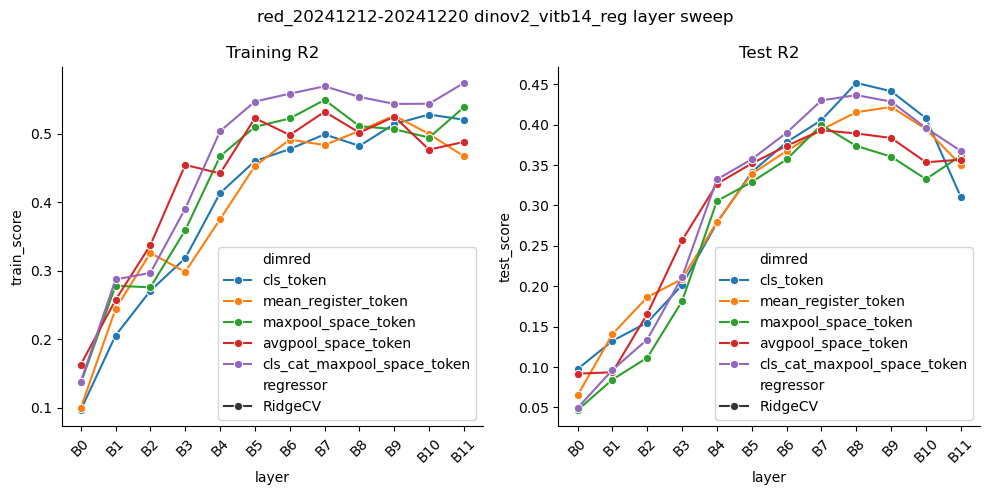

In [62]:
layer_shorten_func = lambda x: x.replace(".blocks.NestedTensorBlock", "B")

figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()

In [63]:
layer_shorten_func = lambda x: x.replace(".blocks.NestedTensorBlock", "B")
figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    figh = plot_result_df_per_layer(result_df_masked, shorten_func=layer_shorten_func)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")


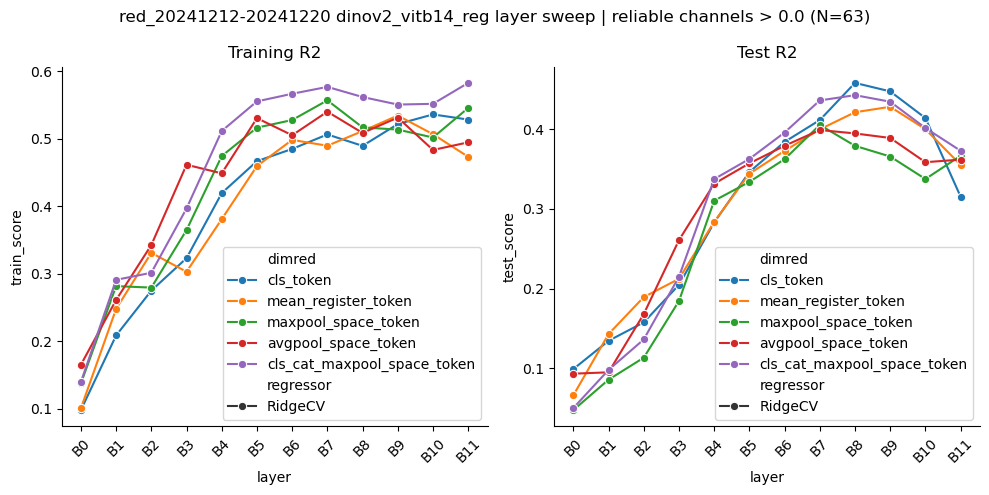

In [65]:
for thresh in [0.0]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    figh = plot_result_df_per_layer(result_df_masked, shorten_func=layer_shorten_func)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()

### Export the models

In [67]:
figdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs'

In [75]:
from neural_regress.sklearn_torchify_lib import LinearLayer_from_sklearn
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"

In [71]:
list(fit_models_lyrswp.keys())

[('.blocks.NestedTensorBlock0_cls_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_mean_register_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_avgpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_cls_cat_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_cls_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_mean_register_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_avgpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_cls_cat_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_cls_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_mean_register_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_avgpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_cls_cat_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock3_cls_token', 'Rid

In [72]:
modelname

'dinov2_vitb14_reg'

In [80]:
for modelname in ["dinov2_vitb14_reg"]:
    Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl")
    readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")
    meta_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    fit_models_lyrswp_RidgeCV = th.load(readout_path)
    Xtfmer_lyrswp_RidgeCV = dill.load(open(Xtransform_path, "rb"))
    pred_data = pkl.load(open(meta_path, "rb"))
    keys = [ ('.blocks.NestedTensorBlock8_cls_token', 'RidgeCV')
             ]
    for key in keys:
        export_readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
        export_Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pkl")
        export_meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

        regressor = fit_models_lyrswp_RidgeCV[key]
        Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
        pred_rsp = pred_data["pred_dict"][key]
        D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
        D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]
        readout = LinearLayer_from_sklearn(regressor)
        th.save(readout.state_dict(), export_readout_path)
        dill.dump(Xtfmer, open(export_Xtransform_path, "wb"))
        th.save({
            "reliability": reliability,
            "ncsnr": ncsnr,
            "D2_per_unit_test": D2_per_unit_test,
            "D2_per_unit_train": D2_per_unit_train
        }, export_meta_path)
        print(f"Saved {export_readout_path}")
        print(f"Saved {export_Xtransform_path}")
        print(f"Saved {export_meta_path}")

Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_dinov2_vitb14_reg_readout_.blocks.NestedTensorBlock8_cls_token_RidgeCV.pth
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_dinov2_vitb14_reg_Xtfmer_.blocks.NestedTensorBlock8_cls_token_RidgeCV.pkl
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_dinov2_vitb14_reg_meta_.blocks.NestedTensorBlock8_cls_token_RidgeCV.pkl


In [81]:
Xtfmer

<function __main__.get_cls_token(X)>

### Testing model

In [82]:
modelname

'dinov2_vitb14_reg'

In [ ]:
import torch
import dill
from os.path import join

device = "cuda"
subject_id = "red_20241212-20241220"
modelname = "dinov2_vitb14_reg"
key = ('.blocks.NestedTensorBlock8_cls_token', 'RidgeCV')
layer_name = '.blocks.NestedTensorBlock8'
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"
readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pkl")
meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

# model, transforms_pipeline = load_model_transform(modelname, device=device)
ckpt_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_backbones'
dinov2_vitb14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
model = dinov2_vitb14_reg.eval().to(device)
model.requires_grad_(False)

fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name, ingraph=True, store_device=device)

state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
Xtransform = dill.load(open(Xtransform_path, "rb"))

# alternatively use this transform, if loading is not working
# def get_cls_token(X):
#     return X[:, 0, :]
# Xtransform = get_cls_token

def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
    
check_gradient(population_prediction)

### Pipeline

In [ ]:
# device = "cuda" if th.cuda.is_available() else "cpu"
# dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
# data_path = join(dataroot, "nsd_shared1000_6monkeys_2024.h5")
# stimroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/shared1000"
# # Load data
# data = load_from_hdf5(data_path)
# print("subjects:", list(data.keys()))

In [ ]:
# subject_id = 'paul_240713-240710'
# for subject_id in ['paul_240713-240710', 
#                    'paul_20240713-20240710', 
#                    'red_20240713-20240710',
#                    'baby1_20240329-20240325', 
#                    'baby1_240329-240325', 
#                    'baby5_240819-240822', ]: 
#%%
batch_size = 64
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
for modelname in ["clipag_vitb32", ]: # 
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset with transforms
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
    # Prepare fetcher
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    module_names = [name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]
    # Add hooks to all layers / blocks in resnet50
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )

    # Record features
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()
    th.cuda.empty_cache()
    #%%
    resp_mat_sel = resp_mat
    print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
    # result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer(feat_dict_lyrswp, 
    #             resp_mat_sel, layer_names=module_names, # 'layer2', 'layer3', 
    #             regressor_list=["Ridge",], dimred_list=["pca1000", "srp", "srp1000", "srp2000"], verbose=True) # "sp_cent", "sp_avg", 
    result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
                resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
                alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                dimred_list=["pca1000", "srp", "srp1000",], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

    pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)
    pkl.dump(pred_D2_dict, 
            open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
    result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
    # th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
    # pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

    # %%
    
    figh = plot_result_df_per_layer(result_df_lyrswp, )
    figh.suptitle(f"{subject_id} {modelname} layer sweep")
    figh.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
    # %%
    # Mask out unreliable channels and plot again
    for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
        channel_count = (reliability > thresh).sum()
        result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                    pred_D2_dict['D2_per_unit_test_dict'], 
                                                    mask=reliability > thresh)
        figh = plot_result_df_per_layer(result_df_masked, )
        figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
        figh.tight_layout()
        figh.show()
        saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
    plt.close("all")
    

### Scratch

In [ ]:
type(model_clip.visual)
from open_clip.transformer import VisionTransformer

open_clip.transformer.VisionTransformer

In [ ]:
model.transformer.resblocks

ModuleList(
  (0-11): 12 x ResidualAttentionBlock(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (ls_1): Identity()
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (c_fc): Linear(in_features=768, out_features=3072, bias=True)
      (gelu): GELU(approximate='none')
      (c_proj): Linear(in_features=3072, out_features=768, bias=True)
    )
    (ls_2): Identity()
  )
)

In [ ]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeLassoCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeLassoCV.pth")) 
th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeLassoCV.pkl"))

In [ ]:
resp_mat_sel = resp_mat
print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
            resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
            alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
            dimred_list=["pca1000", "avgtoken", "clstoken"], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

Fitting models for All channels N=64
.transformer.resblocks.ResidualAttentionBlock0 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 pca1000 [1028, 1000]: 0.146s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 avgtoken [1028, 768]: 0.013s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0: 0.159s
.transformer.resblocks.ResidualAttentionBlock1 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 pca1000 [1028, 1000]: 0.147s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 avgtoken [1028, 768]: 0.012s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1: 0.159s
.transformer.resblocks.ResidualAttentionBlock2 torch.Si

In [ ]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

In [ ]:
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)

In [ ]:
fetcher.module_names

OrderedDict([('0', 'Image'),
             ('1', '.Conv2dconv1'),
             ('2', '.Identitypatch_dropout'),
             ('3', '.LayerNormln_pre'),
             ('4', '.transformer.resblocks.0.LayerNormln_1'),
             ('5', '.transformer.resblocks.0.MultiheadAttentionattn'),
             ('6', '.transformer.resblocks.0.Identityls_1'),
             ('7', '.transformer.resblocks.0.LayerNormln_2'),
             ('8', '.transformer.resblocks.0.mlp.Linearc_fc'),
             ('9', '.transformer.resblocks.0.mlp.GELUgelu'),
             ('10', '.transformer.resblocks.0.mlp.Linearc_proj'),
             ('11', '.transformer.resblocks.0.mlp'),
             ('12', '.transformer.resblocks.0.Identityls_2'),
             ('13', '.transformer.resblocks.ResidualAttentionBlock0'),
             ('14', '.transformer.resblocks.1.LayerNormln_1'),
             ('15', '.transformer.resblocks.1.MultiheadAttentionattn'),
             ('16', '.transformer.resblocks.1.Identityls_1'),
             ('17', 

In [ ]:
[name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]

['.transformer.resblocks.ResidualAttentionBlock0',
 '.transformer.resblocks.ResidualAttentionBlock1',
 '.transformer.resblocks.ResidualAttentionBlock2',
 '.transformer.resblocks.ResidualAttentionBlock3',
 '.transformer.resblocks.ResidualAttentionBlock4',
 '.transformer.resblocks.ResidualAttentionBlock5',
 '.transformer.resblocks.ResidualAttentionBlock6',
 '.transformer.resblocks.ResidualAttentionBlock7',
 '.transformer.resblocks.ResidualAttentionBlock8',
 '.transformer.resblocks.ResidualAttentionBlock9',
 '.transformer.resblocks.ResidualAttentionBlock10',
 '.transformer.resblocks.ResidualAttentionBlock11']